In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI as prop
from CoolProp.CoolProp import PhaseSI as phase



In [2]:
#############################################
### Correlations and functions definition ###
#############################################

def f_chur(Re,D):
    
    rug = 0.0046e-2 #Rugosidade para o alumínio em m
    A = (2.457*np.log(1/((7/Re)**0.9+0.27*(rug/D))))**16
    B = (37530/Re)**16
    parameter = 8*((8/Re)**12 + (A+B)**(-3/2))**(1/12)
    
    return(parameter)

def dpdz_mull_heck(x,G,D,f_l,rho_l,f_v,rho_v):
    
    dpdz_lo = f_l*G**2/(2*D*rho_l)
    dpdz_vo = f_v*G**2/(2*D*rho_v)
    A = dpdz_lo+2*(dpdz_vo-dpdz_lo)*x
    parameter = A*(1-x)**(1/3) + dpdz_vo*x**3
    
    return(parameter)

def Xtt(x,G,D,f_l,rho_l,f_v,rho_v):
    
    dpdz_l = 2*f_l*G**2*(1-x)**2/(D*rho_l)
    dpdz_v = 2*f_v*G**2*x**2/(D*rho_v)
    parameter = math.sqrt(dpdz_l/dpdz_v)
    
    return(parameter)


def  eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,D):
    
    Nu_lo = Re_lo**(4/5)*Pr_lo**0.4
    eta_lo = Nu_lo*k_lo/D
    parameter = eta_lo*3.3775*xtt**-0.6285
    
    return(parameter)

def  eta_mono(Re,Pr,k,D):
    
    Nu = 0.023*Re**(4/5)*Pr**(1/3)
    parameter = Nu*k/D

    return(parameter)

def eta_air(Re_air,Pr_air,G_air,cp_air,Ap,Af):
    
    eps= (Ap+Af)/Ap
    j = 0.138*Re_air**(-0.281)*eps**(-0.407)
    St = j*Pr_air**(-2/3)
    parameter = St*G_air*cp_air
    
    return(parameter)

def surf_eff(Ap,Af,D_in,delta,eta_ar,k_al,x_t,x_l):
    
    r=D_in/2
    M=x_t
    L=math.sqrt((x_t/2)**2+x_l**2)    
    phi=L/M
    psi=M/r
    R_eq = r*1.27*psi*(phi-0.3)**(1/2)
    
    m=math.sqrt(2*eta_ar/(k_al*delta))
    var_phi = (R_eq/r -1)*(1+0.35*np.log(R_eq/r))
    eff_fin=np.tanh(m*r*var_phi)/(m*r*var_phi)
    parameter = 1-(1-eff_fin)*(Af/(Ap+Af))
    
    return(parameter)
    
def epsilon(C_ar,C_r134a,NTU,phase_r134a):
    
    if phase_r134a == '' or phase_r134a  == 'twophase':
        
        parameter = 1 - np.exp(-NTU)
    
    else: 
        
        if C_ar > C_r134a:
        
            c = C_r134a/C_ar
            parameter = 1 - np.exp(-(1/c)*(1-np.exp(-c*NTU)))
            
        if C_ar < C_r134a:
            
            c = C_ar/C_r134a
            parameter = (1/c)*(1-np.exp(1-c*(1-np.exp(-NTU))))
    
    return(parameter)



In [3]:
###############################
### Equações de conservação ###
###############################

def movimento(Pin,W,Di,G,v,mu_l):
    
    Re = G*Di/mu_l
    f = f_chur(Re,Di)
    tau = f*G**2*v/8
    parameter = Pin - tau*np.pi*W*4/(np.pi*Di)
    
    return(parameter)

def energia_bi(hin,Pin,Pavg,Qavg,mfrin,Tain,Taavg,Pa,mfra,W,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl):
    
    mu_l =prop('V','P',Pavg,'Q',0,'R134a')
    mu_v = prop('V','P',Pavg,'Q',1,'R134a')
    rho_l = prop('D','P',Pavg,'Q',0,'R134a')
    rho_v = prop('D','P',Pavg,'Q',1,'R134a')
    
    G = mfrin/(np.pi*Di**2/4)
    G_l = G*(1-Qavg)
    G_v = G*Qavg
    Re_l = G_l*Di/mu_l
    Re_v = G_v*Di/mu_v
    f_l =f_chur(Re_l,Di)
    f_v =f_chur(Re_v,Di)
    
    xtt = Xtt(Qavg,G,Di,f_l,rho_l,f_v,rho_v)
    Re_lo = G*Di/prop('V','P',Pavg,'Q',0,'R134a')
    Pr_lo = prop('PRANDTL','P',Pavg,'Q',0,'R134a')
    k_lo = prop('L','P',Pavg,'Q',0,'R134a')
    
    etabi=eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,Di)
    Tin = prop('T','P',Pin,'H',hin,'R134a')
    
    rho_a = prop('D','T',Taavg,'P',Pa,'Air')
    mu_a = prop('D','T',Taavg,'P',Pa,'Air')
    Pr_a = prop('PRANDTL','T',Taavg,'P',Pa,'Air')
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    #mfr_a = rho_a*vfrin
    G_a= (mfra/A_c)
    Re_a = G_a*D_o/mu_a
    
    eta_a = eta_air(Re_a,Pr_a,G_a,cp_a,A_p,A_s)
    eff_surf = surf_eff(A_p,A_s,Di,deltaf,eta_a,kal,xt,xl)

    C_a = mfra*cp_a
    cp_r=prop('C','P',Pavg,'Q',Qavg,'R134a')
    C_r = mfrin*cp_r
    Ph = phase('P',Pavg,'Q',Qavg,'R134a')

    UA = (1/(etabi*np.pi*Di*W) + 1/(eff_surf*eta_a*A_t))**-1
    Ntu = UA/C_a

    eff = epsilon(C_a,C_r,Ntu,'twophase')
    parameter2 = eff*C_a*(Tain-Tin)
    parameter = hin + parameter2*4/(G*np.pi*Di**2)
    
    return(parameter,parameter2)


def energia_mono(hin,Pin,Pavg,havg,mfrin,Tain,Taavg,Pa,mfra,W,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl):
    
    mu_v = prop('V','P',Pavg,'H',havg,'R134a')
    rho_v = prop('D','P',Pavg,'H',havg,'R134a')
    Pr_v = prop('PRANDTL','P',Pavg,'H',havg,'R134a')
    k_v = prop('L','P',Pavg,'H',havg,'R134a')
    
    G = mfrin/(np.pi*Di**2/4)
    Re_v = G*Di/mu_v
    f_v =f_chur(Re_v,Di)
   
    etamono=eta_mono(Re_v,Pr_v,k_v,Di)
    Tin = prop('T','P',Pin,'H',hin,'R134a')
    
    rho_a = prop('D','T',Taavg,'P',Pa,'Air')
    mu_a = prop('D','T',Taavg,'P',Pa,'Air')
    Pr_a = prop('PRANDTL','T',Taavg,'P',Pa,'Air')
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    #mfr_a = rho_a*vfrin
    G_a= (mfra/A_c)
    Re_a = G_a*D_o/mu_a
    
    eta_a = eta_air(Re_a,Pr_a,G_a,cp_a,A_p,A_s)
    eff_surf = surf_eff(A_p,A_s,Di,deltaf,eta_a,kal,xt,xl)

    C_a = mfra*cp_a
    cp_v=prop('C','P',Pavg,'H',havg,'R134a')
    C_v = mfrin*cp_v
    #Ph = phase('P',Pavg,'Q',Qavg,'R134a')

    UA = (1/(etamono*np.pi*Di*W) + 1/(eff_surf*eta_a*A_t))**-1
    Ntu = UA/min(C_a,C_v)

    eff = epsilon(C_a,C_v,Ntu,'gas')
    parameter2 = eff*min(C_a,C_v)*(Tain-Tin)
    parameter = hin + parameter2*4/(G*np.pi*Di**2)
    
    return(parameter,parameter2)

def wall_temp(Travg,eta_r,Di,W,Taavg,eta_a,A_t):
    
    parameter=(Travg*eta_r*np.pi*Di*W + Taavg*eta_a*A_t)/(eta_r*np.pi*Di*W + eta_a*A_t)
    
    return(parameter)

def energia_ar(Tain,Taavg,Pa,mfra,Q_ht):
    
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    parameter = Tain - Q_ht/(mfra*cp_a)
    
    return(parameter)


    

In [4]:
################
### Geometry ###
################

W=300e-3
L = 190e-3
H=60e-3
nt_l = 10
nt_v = 2
delta_f = 0.15e-3
x_t = 11e-3
x_l = 19e-3
D_i = 6.7e-3
D_o=7.9e-3
L_t=W

# Region I

nf_I = 23
nt_I = 6
L_I = 3*x_l
Ap_I = np.pi*D_o*(W-nf_I*delta_f)*nt_I+2*(L_I*H - np.pi*D_o**2/4*nt_I)
As_I = 2*(L_I*H - np.pi*D_o**2/4*nt_I)*(nf_I+1)+H*delta_f*nf_I
At_I = Ap_I+As_I

two_a_I = (x_t - D_o) - (x_t-D_o)*delta_f*nf_I/W
b_I = ((x_t/2)**2+x_l**2)**(1/2) - D_o - (x_t-D_o)*delta_f*nf_I/W

c_I = min(two_a_I,2*b_I)

Ac_I = (H/x_t-1)*c_I*W+(x_t-D_o)*W -(x_t - D_o)*delta_f*nf_I 

# Region II

nf_II = 47
nt_II = 6
L_II = 3*x_l
Ap_II = np.pi*D_o*(W-nf_II*delta_f)*nt_II+2*(L_II*H - np.pi*D_o**2/4*nt_II)
As_II = 2*(L_II*H - np.pi*D_o**2/4*nt_II)*(nf_II+1)
At_II = Ap_II+As_II

two_a_II = (x_t - D_o) - (x_t-D_o)*delta_f*nf_II/W
b_II = ((x_t/2)**2+x_l**2)**(1/2) - D_o - (x_t-D_o)*delta_f*nf_II/W

c_II = min(two_a_II,2*b_II)

Ac_II = (H/x_t-1)*c_II*W+(x_t-D_o)*W -(x_t - D_o)*delta_f*nf_II

# Region III

nf_III = 47
nt_III = 8
L_III = 4*x_l
Ap_III = np.pi*D_o*(W-nf_III*delta_f)*nt_III+2*(L_III*H - np.pi*D_o**2/4*nt_III)
As_III = 2*(L_III*H - np.pi*D_o**2/4*nt_III)*(nf_III+1)+H*delta_f*nf_III
At_III = Ap_III+As_III

two_a_III = (x_t - D_o) - (x_t-D_o)*delta_f*nf_III/W
b_III = ((x_t/2)**2+x_l**2)**(1/2) - D_o - (x_t-D_o)*delta_f*nf_III/W

c_III = min(two_a_III,2*b_III)

Ac_III = (H/x_t-1)*c_III*W+(x_t-D_o)*W -(x_t - D_o)*delta_f*nf_III

At_III, Ac_III


(0.4670387363772634, 0.004953518181818179)

In [5]:
###############
### Circuit ###
###############

j_circuit=np.zeros((10,2))

for k in range(2):
  
    for j in range(10):
        
        if k == 0:
            j_circuit[j][k] = 9-j
        else:
            j_circuit[j][k] = 9+1+j

def j_index(value,jcircuit):
    
    ind_1, ind_2 = np.where(jcircuit == value)

    return(ind_1,ind_2)

In [6]:
##############################
### Inputs and first guess ###
##############################

Pr_inlet = 0.785e5
Q_inlet = 0.43
Tr_inlet = prop('T','P',Pr_inlet,'Q',Q_inlet,'R134a')
hr_inlet = prop('H','P',Pr_inlet,'Q',Q_inlet,'R134a')
hr_outlet = prop('H','P',Pr_inlet,'Q',1,'R134a')
Ta_inlet = -14.8+273.15#-15+273.15
mfrr_inlet = 2.8/3600
G_r = mfrr_inlet/(np.pi*D_i**2/4)
vfra_inlet = 49.3/3600#50/3600
Pa_inlet = 101325
rhoa_inlet = prop('D','P',Pa_inlet,'T',Ta_inlet,'Air')
mfra_inlet = rhoa_inlet*vfra_inlet
k_al = 237

hr_in = np.linspace(hr_inlet,hr_outlet,20)#np.ones((20))*hr_inlet 
hr_out = np.linspace(hr_inlet,hr_outlet,20)#np.ones((20))*hr_inlet

Tref_in=np.zeros((20))
Tref_out=np.zeros((20))

Pr_in=np.ones((20))*Pr_inlet
Pr_out=np.ones((20))*Pr_inlet

Qr_in=np.ones((20))
Qr_out=np.ones((20))
Qr_in[0]=Q_inlet
Q_ht_r=np.zeros((20))
#eta_r=np.zeros((20))
#eta_airside=np.zeros((20))
#Tw=np.ones((20))*(Tr_inlet+1)

Ta_in=np.linspace(Ta_inlet,Tr_inlet,10)#np.ones((10))*(Tr_inlet)
Ta_out=np.linspace(Ta_inlet,Tr_inlet,10)#np.ones((10))*(Tr_inlet)
Ta_in[0]=Ta_inlet

hr_out_cycle = np.zeros((20))
Pr_out_cycle = np.zeros((20))
Ta_out_cycle = np.zeros((10))

Ap=np.zeros((10,2))
As=np.zeros((10,2))
At=np.zeros((10,2))
Ac=np.zeros((10,2))

Ap[0:4,:]=Ap_I
Ap[4:7,:]=Ap_II
Ap[7:10,:]=Ap_III

As[0:4,:]=As_I
As[4:7,:]=As_II
As[7:10,:]=As_III

Ac[0:4,:]=Ac_I
Ac[4:7,:]=Ac_II
Ac[7:10,:]=Ac_III

At[0:4,:]=Ap_I+As_I
At[4:7,:]=Ap_II+As_III
At[7:10,:]=Ap_III+As_III


In [7]:
####################
### Main Routine ###
####################

alpha = 0.2
alpha2 = 0.2
alpha3 = 0.5

for res_cycle in range(50):
    
    hr_out_cycle_old = np.copy(hr_out)
    Pr_out_cycle_old = np.copy(Pr_out)
    Ta_out_cycle_old = np.copy(Ta_out)
    
    for ind in range(20):

        ind_j,ind_k = j_index(ind,j_circuit)
        Tr_in = prop('T','P',Pr_in[ind],'H',hr_in[ind],'R134a')
        Ta_avg = (Ta_in[int(ind_j)]+Ta_out_cycle_old[int(ind_j)])/2 
        Q_in = abs(prop('Q','P',Pr_in[ind],'H',hr_in[ind],'R134a'))
        #Q_out = abs(prop('Q','P',Pr_out_cycle_old[ind],'H',hr_out_cycle_old[ind],'R134a'))
        Pr_out_old_it = float(np.copy(Pr_out_cycle_old[ind]))
        hr_out_old_it = float(np.copy(hr_out_cycle_old[ind]))
        
        for res in range(50):
            
            Pr_out_old = Pr_out_old_it
            hr_out_old = hr_out_old_it
            Pr_avg = (Pr_in[ind]+Pr_out_old)/2
            hr_avg = (hr_in[ind]+hr_out_old)/2
            Q_out = abs(prop('Q','P',Pr_out_old,'H',hr_out_old,'R134a'))
            
            Q_avg = (Q_in+Q_out)/2

            rho_r = prop('D','P',Pr_avg,'H',hr_avg,'R134a')
            v_r = 1/rho_r

            if Q_in < 1 :
                mu_r = prop('V','P',Pr_avg,'Q',0,'R134a')
                Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                hr_out_new,Q_ht_r[ind] = energia_bi(hr_in[ind],Pr_in[ind],Pr_avg,Q_avg,mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l)

            elif Q_in == 1 : #phase_r_in == 'gas' or phase_r_in == 'supercritical_gas':
                mu_r = prop('V','P',Pr_avg,'H',hr_avg,'R134a')
                Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                hr_out_new,Q_ht_r[ind] = energia_mono(hr_in[ind],Pr_in[ind],Pr_avg,hr_avg,mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l)
   
            Pr_out_old_it = alpha*Pr_out_old + (1-alpha)*Pr_out_new
            hr_out_old_it = alpha*hr_out_old + (1-alpha)*hr_out_new

        Pr_out_cycle[ind]= Pr_out_new
        hr_out_cycle[ind]= hr_out_new

    for ind2 in range(10):
        
        tube_index = j_circuit[ind2]
        Ta_out_old_it = float(np.copy(Ta_out_cycle_old[ind2]))
        
        for res in range(50):
            
            Ta_out_old = Ta_out_old_it
            Tair_avg = (Ta_in[ind2]+Ta_out_old)/2
            Q_ht_air = Q_ht_r[int(tube_index[0])] + Q_ht_r[int(tube_index[1])]
            Ta_out_new = energia_ar(Ta_in[ind2],Tair_avg,Pa_inlet,mfra_inlet,Q_ht_air)       
            Ta_out_old_it = alpha2*Ta_out_old + (1-alpha2)*Ta_out_new
        
        Ta_out_cycle[ind2] = Ta_out_new
           
    for ind3 in range(20):
        
        hr_out[ind3] = hr_out_cycle_old[ind3]*alpha3 + hr_out_cycle[ind3]*(1-alpha3) 
        Pr_out[ind3] = Pr_out_cycle_old[ind3]*alpha3 + Pr_out_cycle[ind3]*(1-alpha3)
        
        if ind3 != 19:

            Pr_in[ind3+1]=Pr_out[ind3]
            hr_in[ind3+1]=hr_out[ind3]

    
    for ind4 in range(10):
        
        Ta_out[ind4] = Ta_out_cycle_old[ind4]*alpha3 + Ta_out_cycle[ind4]*(1-alpha3)
        
        if ind4 != 9:

            Ta_in[ind4+1]=Ta_out[ind4]
    
for index in range(20):
    
    Qr_out[index] = abs(prop('Q','P',Pr_out[index],'H',hr_out[index],'R134a'))
    Qr_in[index] = abs(prop('Q','P',Pr_in[index],'H',hr_in[index],'R134a'))
    Tref_out[index] = abs(prop('T','P',Pr_out[index],'H',hr_out[index],'R134a'))
    Tref_in[index] = abs(prop('T','P',Pr_in[index],'H',hr_in[index],'R134a'))




    '''for ind3 in range(20):
        
        ind_j,ind_k = j_index(ind3,j_circuit)
        Tr_avg = (Tr_in[ind3]+Tr_out[ind3])/2
        Ta_avg = (Ta_in[ind_j]+Ta_out[ind_j])/2
        Tw_old = np.copy(Tw[ind3])
        
        Tw_new = wall_temp(Tr_avg,eta_r[ind3],D_i,W,Ta_avg,eta_airside[ind3],At[ind_j,ind_k])
        Tw[ind3] = alpha2*Tw_old + (1-alpha2)*Tw_new'''


In [8]:
 hr_out_cycle_old[ind3]*alpha3 + hr_out_cycle[ind3]*(1-alpha3)

396560.1682588551

In [9]:
print((Pr_out - Pr_out_cycle_old)/Pr_out)
print((hr_out - hr_out_cycle_old)/hr_out)
print((Ta_out - Ta_out_cycle_old)/Ta_out)

[ 3.80137627e-05  4.97448754e-05  4.00023748e-05 -3.07285040e-06
 -6.65395572e-05 -8.49978730e-05  2.19319738e-05  2.44605868e-04
  4.40140534e-04  4.55761335e-04  2.97214036e-04  1.22934869e-04
  6.90965802e-05  1.30717728e-04  2.15588176e-04  2.57119122e-04
  2.51369295e-04  2.21250462e-04  1.80065900e-04  1.25574095e-04]
[-4.02750645e-03 -1.97534450e-03 -7.65621814e-04 -1.56641768e-04
 -4.02064391e-06 -1.17308043e-04 -2.54066530e-04 -2.73619604e-04
 -1.96710107e-04 -1.06528274e-04 -5.07384538e-05 -2.87840973e-05
 -2.46385851e-05 -2.98596240e-05 -4.25223427e-05 -6.27222306e-05
 -9.16092000e-05 -1.33562933e-04 -2.01383167e-04 -3.23195619e-04]
[-9.56079068e-06 -2.26696518e-05 -4.22034459e-05 -6.72627134e-05
 -9.67182033e-05 -1.35816110e-04 -2.01398105e-04 -3.30710347e-04
 -6.09878049e-04 -3.55976950e-04]


In [10]:
Tsat=prop('T','P',Pr_out[-1],'Q',0.5,'R134a')
print('Q = ',np.sum(Q_ht_r))
print('Tr = ',Tref_out[-1]-Tsat)
print('Ta = ',np.average(Ta_out[-1])-273.15)

Q =  104.58446557679106
Tr =  22.691065513755746
Ta =  -19.46848781367231


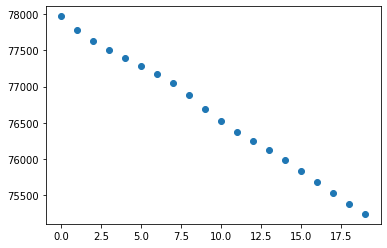

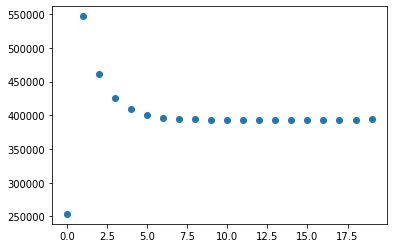

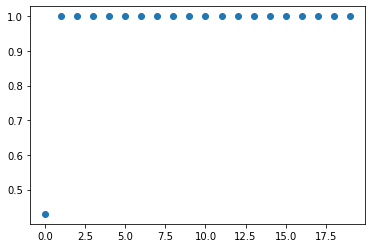

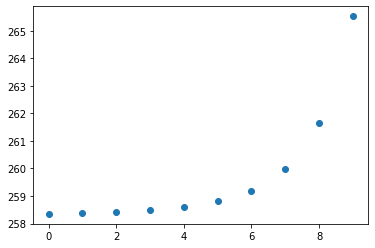

In [11]:
plt.plot(Pr_out,'o')
plt.show()
plt.plot(hr_in,'o')
plt.show()
plt.plot(Qr_in,'o')
plt.show()
plt.plot(Ta_in,'o')
plt.show()



    hr_in = 
    hr_out =  
    Tr_in =
    Tr_out =
    Pr_in = 
    Pr_out = 
    Q_in = 
    Q_out = 
    Q_ht_r = 
    eta_r = 
    eta_airside = 
    Ta_in=np.ones((10))*(Ta_inlet)
    Ta_out=np.ones((10))*(Tr_inlet)

h_in=prop('H','P',0.785e5,'Q',0.43,'R134a')
#hin,Pin,Pavg,Qavg,mfrin,Tain,Pa,mfra,Tw,W,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl
h_out,qtrasnf=energia_bi(h_in,0.785e5,0.784e5,0.45,2.8/3600,273.15-30,273.15-30,101325,50/3600,273.15-31.5,300e-3,D_i,Ac[0,0],Ap[0,0],As[0,0],At[0,0],delta_f,k_al,x_t,x_l)
print(h_out)
print(h_in)
print(prop('Q','P',0.783e5,'H',h_out,'R134a'))
qtrasnf


h_in=prop('H','P',0.785e5,'Q',1,'R134a')
#hin,Pin,Pavg,Qavg,mfrin,Tain,Pa,mfra,Tw,W,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl
h_out,qtrasnf=energia_mono(h_in,0.785e5,0.784e5,h_in+100,2.8/3600,273.15-25,273.15-30,101325,50/3600,273.15-31.5,300e-3,D_i,Ac[0,0],Ap[0,0],As[0,0],At[0,0],delta_f,k_al,x_t,x_l)
print(h_out)
print(h_in)
print(prop('Q','P',0.783e5,'H',h_out,'R134a'))
print(prop('T','P',0.785e5,'H',h_in,'R134a'))
print(prop('T','P',0.785e5,'H',h_out,'R134a'))



# testes das correlações

G = mfr_inlet/(np.pi*D_i**2/4)
G_l = G*(1-Qr_inlet)
G_v = G*Qr_inlet
rho_l = prop('D','P',Pr_inlet,'Q',0,'R134a')
rho_v = prop('D','P',Pr_inlet,'Q',1,'R134a')
rho_bi = prop('D','P',Pr_inlet,'Q',Qr_inlet,'R134a')
mu_l =prop('V','P',Pr_inlet,'Q',0,'R134a')
mu_v = prop('V','P',Pr_inlet,'Q',1,'R134a')
Re_l = G_l*D_i/mu_l
Re_v = G_v*D_i/mu_v
Re_bi = G*D_i/mu_l
f_l =f_chur(Re_l,D_i)
f_v =f_chur(Re_v,D_i)
f_bi = f_chur(Re_bi,D_i)


dp = dpdz_mull_heck(Qr_inlet,G,D_i,f_l,rho_l,f_v,rho_v)
xtt = Xtt(Qr_inlet,G,D_i,f_l,rho_l,f_v,rho_v)

Re_lo = G*D_i/prop('V','P',Pr_inlet,'Q',0,'R134a')
Pr_lo = prop('PRANDTL','P',Pr_inlet,'Q',0,'R134a')
k_lo = prop('L','P',Pr_inlet,'Q',0,'R134a')

eta_bi=eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,D_i)

rho_a = prop('D','T',Ta_inlet,'P',Pa_inlet,'Air')
mu_a = prop('D','T',Ta_inlet,'P',Pa_inlet,'Air')
Pr_a = prop('PRANDTL','T',Ta_inlet,'P',Pa_inlet,'Air')
cp_a = prop('C','T',Ta_inlet,'P',Pa_inlet,'Air')
mfr_a = rho_a*vfr_inlet
G_a= (mfr_a/Ac[0,0])
Re_a = G_a*D_o/mu_a

eta_a = eta_air(Re_a,Pr_a,G_a,cp_a,Ap[0,0],As[0,0])
eff_surf = surf_eff(Ap[0,0],As[0,0],D_i,delta_f,eta_a,k_al,x_t,x_l)

C_a = mfr_a*cp_a
cp_r=prop('C','P',Pr_inlet,'Q',Qr_inlet,'R134a')
C_r = mfr_inlet*cp_r
Ph = phase('P',Pr_inlet,'Q',Qr_inlet,'R134a')

UA = (1/(eta_bi*np.pi*D_i*W) + 1/(eff_surf*eta_a*At[0,0]))**-1
Ntu = UA/C_a

eff = epsilon(C_a,C_r,Ntu,Ph)


def energia_bi(hin,Pin,Pavg,Qavg,Tw,W,G,Di):
    
    mu_l =prop('V','P',Pavg,'Q',0,'R134a')
    mu_v = prop('V','P',Pavg,'Q',1,'R134a')
    rho_l = prop('D','P',Pavg,'Q',0,'R134a')
    rho_v = prop('D','P',Pavg,'Q',1,'R134a')
    
    G_l = G*(1-Qavg)
    G_v = G*Qavg
    Re_l = G_l*Di/mu_l
    Re_v = G_v*Di/mu_v
    f_l =f_chur(Re_l,Di)
    f_v =f_chur(Re_v,Di)
    
    xtt = Xtt(Qavg,G,Di,f_l,rho_l,f_v,rho_v)
    Re_lo = G*Di/prop('V','P',Pavg,'Q',0,'R134a')
    Pr_lo = prop('PRANDTL','P',Pavg,'Q',0,'R134a')
    k_lo = prop('L','P',Pavg,'Q',0,'R134a')
    
    etabi=eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,Di)
    Tin = prop('T','P',Pin,'H',hin,'R134a')
    qi = etabi*(Tin - Tw)
    parameter = hin - qi*np.pi*W*4/(G*np.pi*Di)
    
    return(parameter)


Temp=20+273.15
Psat = prop('P','T',T,'Q',0,'R134a')
p=phase('T',Temp,'Q',0.5,'R134a')

if p == '' or p  == 'twophase':
    print('ok')
    
    
Visco1= prop('V','T',Temp,'Q',0,'R134a')
Visco2= prop('V','T',Temp,'P',101325,'air')
rho2 = prop('D','T',273.15,'P',101325,'air')

mfr2 = (rho2*50/3600)/24
Area = ((300e-3-23*0.15e-3)*(60e-3 - 2*7.9e-3))/24
espc = (300e-3-23*0.15e-3)/24
G=mfr2/Area


mfr = 2.8/3600
D = 6.7e-3

Re=4*mfr/D/Visco1
Re2=G*espac/Visco2
Re2
#((1.4*50/3600)/Ac[9,1])*D_o/Visco2

####################
### Main Routine ###
####################

alpha = 0.5
alpha2 = 0.5

for res_cycle in range(10):
    
    hr_in_cycle = np.copy(hr_in) 
    hr_out_cycle = np.copy(hr_out) 
    Pr_in_cycle = np.copy(hr_out)
    Pr_out_cycle = np.copy(hr_out)
    Ta_in_cycle = np.copy(hr_out)
    Ta_out_cycle = np.copy(hr_out)
        
    for ind in range(20):

            ind_j,ind_k = j_index(ind,j_circuit)
            Tr_in[ind] = prop('T','P',Pr_in_cycle[ind],'H',hr_in_cycle[ind],'R134a')
            Ta_avg = (Ta_in_cycle[int(ind_j)]+Ta_out_cycle[int(ind_j)])/2 
            #Q_out_old = np.copy(Q_out[ind])
            #Ta_in_avg = np.average(Ta_in[ind_j])

            for res in range(10):
                
                Pr_out_old = np.copy(Pr_out_cycle[ind])
                hr_out_old = np.copy(hr_out_cycle[ind])
                Pr_avg = (Pr_in_cycle[ind]+Pr_out_old)/2
                hr_avg = (hr_in_cycle[ind]+hr_out_old)/2
                Q_ind[ind] = abs(prop('Q','P',Pr_in_cycle[ind],'H',hr_in_cycle[ind],'R134a'))
                
                Q_avg = (Q_in[ind]+Q_out[ind])/2
                                
                rho_r = prop('D','P',Pr_avg,'H',hr_avg,'R134a')
                v_r = 1/rho_r
                
                if Q_in[ind] < 1:#phase_r_in == 'twophase' or phase_r_in == '':
                    mu_r = prop('V','P',Pr_avg,'Q',0,'R134a')
                    Pr_out_new = movimento(Pr_in_cycle[ind],W,D_i,G_r,v_r,mu_r)
                    hr_out_new,Q_ht_r[ind],eta_r[ind],eta_airside[ind] = energia_bi(hr_in_cycle[ind],Pr_in_cycle[ind],Pr_avg,Q_avg,mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l)

                    Pr_out[ind]= alpha*Pr_out_old + (1-alpha)*Pr_out_new
                    hr_out[ind]= alpha*hr_out_old + (1-alpha)*hr_out_new
                    Tr_out[ind] = prop('T','P',Pr_out[ind],'H',hr_out[ind],'R134a')
                    Q_out[ind] = abs(prop('Q','P',Pr_out[ind],'H',hr_out[ind],'R134a'))

                else: #phase_r_in == 'gas' or phase_r_in == 'supercritical_gas':
                    mu_r = prop('V','P',Pr_avg,'H',hr_avg,'R134a')
                    Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                    hr_out_new,Q_ht_r[ind],eta_r[ind],eta_airside[ind] = energia_mono(hr_in[ind],Pr_in[ind],Pr_avg,hr_avg,mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l)

                    Pr_out[ind]= alpha*Pr_out_old + (1-alpha)*Pr_out_new
                    hr_out[ind]= alpha*hr_out_old + (1-alpha)*hr_out_new
                    Tr_out[ind] = prop('T','P',Pr_out[ind],'H',hr_out[ind],'R134a')
                    Q_out[ind] = abs(prop('Q','P',Pr_out[ind],'H',hr_out[ind],'R134a'))
                
            if ind != 19:

                Pr_in[ind+1]=np.copy(Pr_out[ind])
                hr_in[ind+1]=np.copy(hr_out[ind])
                Q_in[ind+1]=np.copy(Q_out[ind])

    for ind2 in range(10):
        
        tube_index = j_circuit[ind2]
        
        for res in range(20):
            
            Ta_out_old = Ta_out[ind2]
            Ta_avg = (Ta_in[ind2]+Ta_out_old)/2
            Q_ht_air = Q_ht_r[int(tube_index[0])] + Q_ht_r[int(tube_index[1])]
            Ta_out_new = energia_ar(Ta_in[ind2],Ta_avg,Pa_inlet,mfra_inlet,Q_ht_air)
            Ta_out[ind2] = alpha2*Ta_out_old + (1-alpha2)*Ta_out_new
            
        if ind2 != 9:

            Ta_in[ind2+1]=np.copy(Ta_out[ind2])   

    '''for ind3 in range(20):
        
        ind_j,ind_k = j_index(ind3,j_circuit)
        Tr_avg = (Tr_in[ind3]+Tr_out[ind3])/2
        Ta_avg = (Ta_in[ind_j]+Ta_out[ind_j])/2
        Tw_old = np.copy(Tw[ind3])
        
        Tw_new = wall_temp(Tr_avg,eta_r[ind3],D_i,W,Ta_avg,eta_airside[ind3],At[ind_j,ind_k])
        Tw[ind3] = alpha2*Tw_old + (1-alpha2)*Tw_new'''
    
Tsat=prop('T','P',Pr_out[-1],'Q',0.5,'R134a')

print(np.sum(Q_ht_r))
print(Tr_out[-1]-Tsat)
print(np.average(Ta_out[-1])-273.15)
